In [64]:
import scib
import numpy as np
from sklearn.metrics import silhouette_score


def eval_scib_metrics(adata, batch_key = "str_batch", label_key = "celltype", embed_key  = "X_scGPT"):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=label_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,#T
        pcr_=False,#T
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,#T  # use the clustering, bias to the best matching
        ari_=True,#T # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()

    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    # remove nan value in result_dict
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    return result_dict


def cal_aws(cell_emb, label):
    asw = silhouette_score(cell_emb, label)
    # return asw
    asw = (asw + 1)/2
    return asw


import pandas as pd
import scanpy as sc
from sklearn.metrics import silhouette_score


def get_pca_emb(adata):
    if 'X_pca' in adata.obsm:
        emb = adata.obsm["X_pca"]
    else:
        if adata.raw is not None:
            adata.X = adata.raw.X
            sc.pp.normalize_total(adata, target_sum=10000)
            sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, subset=True)
        sc.pp.scale(adata)
        sc.pp.pca(adata)
        emb = adata.obsm["X_pca"]
    pca_cell_emb = pd.DataFrame(emb, index = adata.obs_names)
    return pca_cell_emb

# cal aws score

In [60]:
import os
from collections import defaultdict
import pickle

scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvgFalse'
datasets = {
            'blood': '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/data/zero-shot/blood/blood.h5ad',
            'kidney': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/kidney.h5ad',
            'Zheng68K': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad',
            'liver': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/liver.h5ad',}

            # '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}
for i in datasets:
    adata = sc.read_h5ad(datasets[i])
    print(i)
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'cell_type'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:

        if model != 'PCA':
            with open(os.path.join(output_dir, i, pkl_map[model]), 'rb') as f: 
                adata.obsm['model'] = pickle.load(f)
                if np.isnan(adata.obsm['model']).sum() > 0:
                    print('cell emb has nan value. ', model, i)
                    adata.obsm['model'][np.isnan(adata.obsm['model'])] = 0
        else:
            pca_emb = get_pca_emb(adata)
            adata.obsm['model'] = pca_emb
        
        aws = cal_aws(adata.obsm['model'], adata.obs[label_key].cat.codes.values)
        print(model, aws)
        scores['data'].append(datasets[i].split('/')[-1].split('.h5ad')[0])
        scores['model'].append(model)
        scores['aws'].append(aws)
df = pd.DataFrame(scores)

fig_dir = './fig2/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir, exist_ok=True)
df.to_csv(fig_dir + './zero-shot_cellemb_aws.csv', index=False)

blood
PCA 0.614904373884201
scBert 0.3217116445302963
scGPT 0.6740530580282211
scFoundation 0.44047462940216064
Geneformer 0.44036387652158737
kidney


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 0.5902285203337669
scBert 0.29945091903209686
scGPT 0.566490888595581
scFoundation 0.3981624096632004
Geneformer 0.4229240342974663


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.1' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.2' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.

Zheng68K


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 0.48444468807429075
scBert 0.41130324453115463
scGPT 0.49993514833477093
scFoundation 0.4762973506003618
Geneformer 0.48612169548869133
liver
PCA 0.605553887784481
scBert 0.3942991942167282
scGPT 0.6008995994925499
scFoundation 0.4446193389594555
Geneformer 0.4564482197165489


# plot aws bar

# single dataset

In [63]:
import matplotlib.pyplot as plt
import numpy as np

model_color = {"scBert": '#a5e7f0', "scGPT": '#93b7e3', "Geneformer": '#a3d9c2', "scFoundation": '#f5e8c8', 'PCA': '#cbb0e3'}
global model_color

def creat_multi_bars(labels, datas, ylabel, legend, tick_step=1, group_gap=0.2, bar_gap=0):
    fig = plt.figure(figsize=(12, 4))
    x= np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    for index, y in enumerate(datas):
        plt.bar(x + index*bar_span, y , bar_width, color=model_color[legend[index]])
    plt.ylabel(ylabel)
    ticks = x + (group_width-bar_span) / 2
    plt.xticks(ticks, labels)
    # plt.legend(loc='upper center', bbox_to_anchor=())
    plt.legend(legend, loc=1, bbox_to_anchor=(1.35, 1))
    # plt.show()
    return fig

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


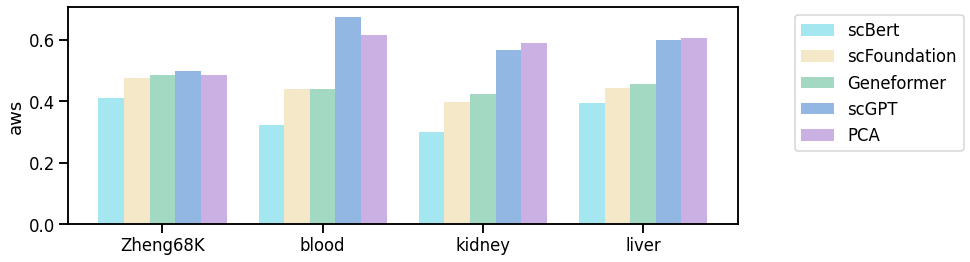

In [62]:
import pandas as pd

fig_dir = './fig2/'
df = pd.read_csv(fig_dir + './zero-shot_cellemb_aws.csv')
df = df[df.data.isin(['liver', 'kidney', 'blood', 'Zheng68K'])]
labels = list(np.unique(df['data']))
models = ['scBert', 'scFoundation', 'Geneformer', 'scGPT', 'PCA']

df = df.set_index('data')
colunms = [ 'aws']
for col in colunms:
    datas = []
    for m in models:
        data = df[df.model == m].loc[labels][col].values
        datas.append(data)

    fig = creat_multi_bars(labels, datas, col, models)
    plt.savefig(fig_dir + './1.zero-shot_cellemb_aws.pdf', bbox_inches='tight')

# hvg

In [66]:
adata

AnnData object with n_obs × n_vars = 7750 × 21231
    obs: 'kit', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'predicted_celltype', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_name', 'highly_deviant', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'default_embedding', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
    obsm: 'X_pca', 'X_umap', 'model'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [67]:
import os

# scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvg'
datasets = {
            # 'Zheng68K': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad',
            'blood': '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/data/zero-shot/blood/blood.h5ad',
            'kidney': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/kidney.h5ad',
            'liver': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/liver.h5ad',}

            # '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}
hvg_list = [500, 1000, 1500, 2000, 3000]
for i in datasets:
    adata = sc.read_h5ad(datasets[i])
    print(i)
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'cell_type'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:
        
        for hvg in hvg_list:
            if model != 'PCA':
                with open(os.path.join(output_dir + str(hvg), i, pkl_map[model]), 'rb') as f: 
                    adata.obsm['model'] = pickle.load(f)
                    if np.isnan(adata.obsm['model']).sum() > 0:
                        print('cell emb has nan value. ', model, hvg, i)
                        adata.obsm['model'][np.isnan(adata.obsm['model'])] = 0
            else:
                pca_emb = get_pca_emb(adata)
                adata.obsm['model'] = pca_emb
            
            aws = cal_aws(adata.obsm['model'], adata.obs[label_key].cat.codes.values)
            print(model, hvg, aws)
            scores['data'].append(datasets[i].split('/')[-1].split('.h5ad')[0])
            scores['model'].append(model)
            scores['hvg'].append(hvg)
            scores['aws'].append(aws)

blood
PCA 500 0.614904373884201
PCA 1000 0.614904373884201
PCA 1500 0.614904373884201
PCA 2000 0.614904373884201
PCA 3000 0.614904373884201
scBert 500 0.39538444578647614
scBert 1000 0.3984159752726555
scBert 1500 0.3833729773759842
scBert 2000 0.3759997710585594
scBert 3000 0.3574356585741043
scGPT 500 0.5140523193404078
scGPT 1000 0.5435360781848431
scGPT 1500 0.5757875889539719
scGPT 2000 0.609511248767376
scGPT 3000 0.6234454065561295
scFoundation 500 0.5359216704964638
scFoundation 1000 0.5393727608025074
scFoundation 1500 0.5255296640098095
scFoundation 2000 0.5140981497243047
scFoundation 3000 0.49041612073779106
Geneformer 500 0.4834718592464924
Geneformer 1000 0.49998969945590943
Geneformer 1500 0.5152360247448087
Geneformer 2000 0.5207985211163759
Geneformer 3000 0.514879303984344
kidney


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 500 0.5901641324162483
PCA 1000 0.5901641324162483
PCA 1500 0.5901641324162483
PCA 2000 0.5901641324162483
PCA 3000 0.5901641324162483
scBert 500 0.4239986464381218
scBert 1000 0.38797272741794586
scBert 1500 0.38564642518758774
scBert 2000 0.37291020154953003
scBert 3000 0.35384616255760193
scGPT 500 0.5127218579873443
scGPT 1000 0.5346867702901363
scGPT 1500 0.5389774069190025
scGPT 2000 0.5484197437763214
scGPT 3000 0.55391775816679
scFoundation 500 0.5185184292495251
scFoundation 1000 0.5033172187395394
scFoundation 1500 0.4909101231023669
scFoundation 2000 0.4833936095237732
scFoundation 3000 0.48044623993337154
Geneformer 500 0.49779188609682024
Geneformer 1000 0.4975746648851782
Geneformer 1500 0.4895605407655239
Geneformer 2000 0.48813052382320166
Geneformer 3000 0.49403798021376133
liver
PCA 500 0.605553887784481
PCA 1000 0.605553887784481
PCA 1500 0.605553887784481
PCA 2000 0.605553887784481
PCA 3000 0.605553887784481
scBert 500 0.3404860198497772
scBert 1000 0.3485381603

In [68]:
df = pd.DataFrame(scores)
df.to_csv('./fig2/zero-shot_cellemb_hvg.csv', index=False)

In [69]:
from collections import  defaultdict
import matplotlib.pyplot as plt
import numpy as np


data  = defaultdict(list)
group_df = df.groupby(['model', 'hvg'])
for (model, hvg), sub_df in group_df:
    print(model, hvg)
    data[model].append(list(sub_df['aws'].values))
print(data)

Geneformer 500
Geneformer 1000
Geneformer 1500
Geneformer 2000
Geneformer 3000
PCA 500
PCA 1000
PCA 1500
PCA 2000
PCA 3000
scBert 500
scBert 1000
scBert 1500
scBert 2000
scBert 3000
scFoundation 500
scFoundation 1000
scFoundation 1500
scFoundation 2000
scFoundation 3000
scGPT 500
scGPT 1000
scGPT 1500
scGPT 2000
scGPT 3000
defaultdict(<class 'list'>, {'Geneformer': [[0.5042789252474904, 0.4834718592464924, 0.49779188609682024, 0.4678807444870472], [0.5049064317718148, 0.49998969945590943, 0.4975746648851782, 0.47375298477709293], [0.5023740765172988, 0.5152360247448087, 0.4895605407655239, 0.47478719986975193], [0.5005942759453319, 0.5207985211163759, 0.48813052382320166, 0.4778255168348551], [0.4993978168349713, 0.514879303984344, 0.49403798021376133, 0.4811861030757427]], 'PCA': [[0.48444468807429075, 0.614904373884201, 0.5901641324162483, 0.605553887784481], [0.48444468807429075, 0.614904373884201, 0.5901641324162483, 0.605553887784481], [0.48444468807429075, 0.614904373884201, 0.59

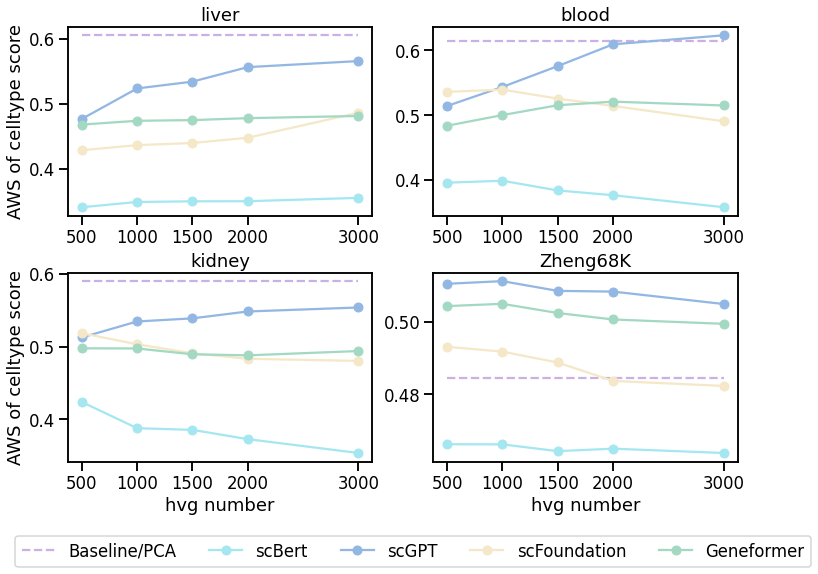

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={"wspace": 0.2, 'hspace': 0.3})

names = ['liver', 'blood', 'kidney', 'Zheng68K']
models = ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']
for i in range(len(names)):
    row =  0 if i < 2 else 1
    col = i if i < 2 else i-2
    ax = axes[row][col]
    plot_df = df[df['data'] == names[i]]
    for model in models:
        tmp_df = plot_df[plot_df['model'] == model].sort_values(by='hvg')
        if model == 'PCA':
            ax.plot(tmp_df['hvg'], tmp_df['aws'], marker=None, color=model_color[model], linestyle='--')
        else:
            ax.plot(tmp_df['hvg'], tmp_df['aws'], marker='o', color=model_color[model]) 
    ax.set_xticks(hvg_list)
    ax.set_title(names[i])
    if row == 1:
        ax.set_xlabel('hvg number')
    if col == 0:
        ax.set_ylabel('AWS of celltype score')
    # ax.set_ylim(0, 1)

plt.legend(['Baseline/PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer'], loc=3, ncol=5,  bbox_to_anchor=(-1.4, -0.6))
plt.savefig('./fig2/3.zero-shot_cellemb_hvg.pdf', bbox_inches='tight')

# integrate

In [100]:
import os
from collections import defaultdict
import pickle

scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/'
datasets = ['dataset1/humanDC.h5ad', 'dataset4/hPancreas.h5ad', 'dataset5/hPBMC.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}

for i in datasets:
    adata = sc.read_h5ad(path + i)
    
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:
        print(model)
        if model != 'PCA':
            with open(os.path.join(output_dir, i.split('/')[0], pkl_map[model]), 'rb') as f: 
                adata.obsm['model'] = pickle.load(f)
                emb_key = 'model'
        else:
            emb_key = 'X_pca'
        res = eval_scib_metrics(adata, batch_key = "batch", label_key = label_key, embed_key  = emb_key)
        scores['data'].append(dataset_name[i.split('/')[0]])
        scores['model'].append(model)
        for score in res:
            scores[score].append(res[score])

aws_df = pd.DataFrame(scores)
aws_df.to_csv(fig_dir + '/zero-shot-integrate_aws.csv', index=False)

PCA
scBert
(576, 200) scBert
scGPT
(576, 512) scGPT
scFoundation
(576, 768) scFoundation
Geneformer
(576, 256) Geneformer
PCA
scBert
(14767, 200) scBert
scGPT
(14767, 512) scGPT
scFoundation
(14767, 768) scFoundation
Geneformer
(14767, 256) Geneformer


MemoryError: Unable to allocate 1.94 GiB for an array with shape (15476, 33694) and data type float32

In [56]:
def creat_multi_bars(labels, datas, xlabel, legend, tick_step=1, group_gap=0.2, bar_gap=0):
    fig = plt.figure(figsize=(4, 8))
    x= np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    for index, y in enumerate(datas):
        plt.barh(x + index*bar_span, y , bar_width, color=model_color[legend[index]])
    plt.xlabel(xlabel)
    ticks = x + (group_width-bar_span) / 2
    plt.yticks(ticks, labels)
    # plt.legend(loc='upper center', bbox_to_anchor=())
    plt.legend(legend, loc=1, bbox_to_anchor=(1.9, 1))
    # plt.show()
    return fig

In [54]:
import pandas as pd

fig_dir = './fig2/'
df = pd.read_csv(fig_dir + './zero-shot-integrate_aws.csv')
df = df.set_index('data')
df

,model,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,avg_bio
data,,,,,,
humanDC,PCA,0.782069,0.818780,0.558458,0.895487,0.719769
humanDC,scBert,0.782069,0.818780,0.517797,0.811545,0.706215
humanDC,scGPT,0.782069,0.818780,0.718301,0.802089,0.773050
humanDC,scFoundation,0.782069,0.818780,0.473598,0.731726,0.691482
humanDC,Geneformer,0.782069,0.818780,0.495974,0.918726,0.698941
hPancreas,PCA,0.644496,0.440330,0.304756,0.333413,0.463194
hPancreas,scBert,0.644496,0.440330,0.250732,0.377800,0.445186
hPancreas,scGPT,0.644496,0.440330,0.487144,0.566172,0.523990
hPancreas,scFoundation,0.644496,0.440330,0.344618,0.618909,0.476481


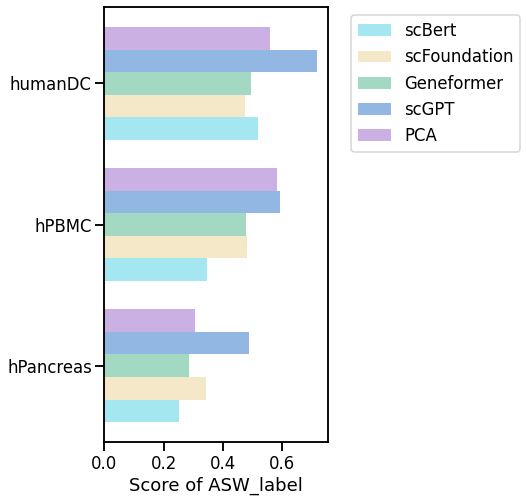

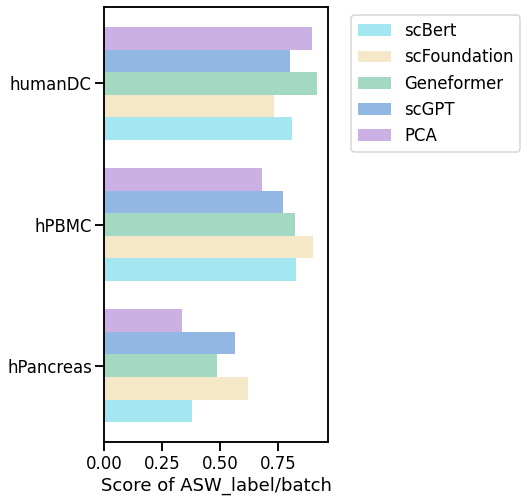

In [57]:

labels = ['hPancreas', 'hPBMC', 'humanDC']
models = ['scBert', 'scFoundation', 'Geneformer', 'scGPT', 'PCA']


colunms = [ 'ASW_label', 'ASW_label/batch']
for col in colunms:
    datas = []
    for m in models:
        data = df[df.model == m].loc[labels][col].values
        datas.append(data)

    fig = creat_multi_bars(labels, datas, 'Score of ' + col, models)
    plt.savefig(fig_dir + f"./2.zero-shot_cellemb_integrate_{col.replace('/', '_')}.pdf", bbox_inches='tight')

# resource 

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('../plots/figs_data.xlsx', sheet_name='fig2-cell_resource')
df

,Name,memory_gpu,Runtime,emb_size,time,cell_num
0,Geneformer,1.940918,210,256,3.198496,10000
1,Geneformer,1.944824,213,256,3.244832,15000
2,Geneformer,1.933105,60,256,0.686592,3000
3,Geneformer,1.935059,119,256,1.629725,5000
4,Geneformer,1.938965,126,256,1.775788,8000
5,scBert,8.353027,584,200,9.436507,10000
6,scBert,8.353027,848,200,13.821744,15000
7,scBert,8.353027,209,200,3.183578,3000
8,scBert,8.353027,317,200,4.951075,5000
9,scBert,8.353027,474,200,7.600174,8000


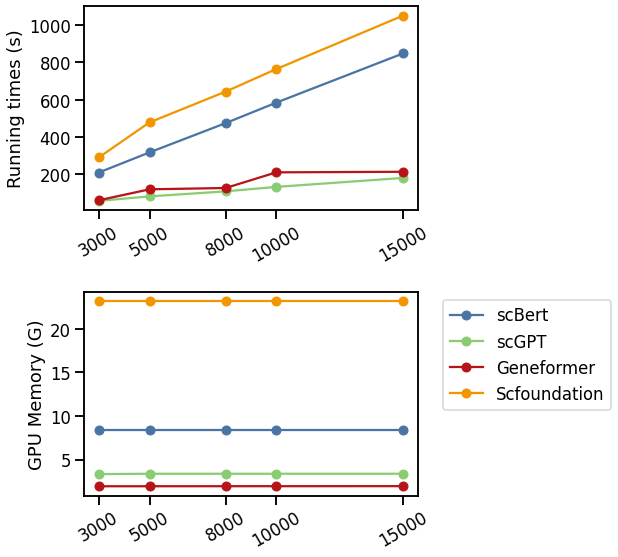

In [129]:

fig = plt.figure(figsize=(6, 9))
plt.subplots_adjust(wspace=0, hspace=0.4)


axes_1 = plt.subplot(211)
tmp_df = df[df['Name'] == 'scBert'].sort_values(by='cell_num')
axes_1.plot(tmp_df['cell_num'], tmp_df['Runtime'], marker='o', color="#4974a4")
tmp_df = df[df['Name'] == 'scGPT'].sort_values(by='cell_num')
axes_1.plot(tmp_df['cell_num'], tmp_df['Runtime'], marker='o', color="#8acc72")
tmp_df = df[df['Name'] == 'Geneformer'].sort_values(by='cell_num')
axes_1.plot(tmp_df['cell_num'], tmp_df['Runtime'], marker='o', color="#b81316")
tmp_df = df[df['Name'] == 'Scfoundation'].sort_values(by='cell_num')
axes_1.plot(tmp_df['cell_num'], tmp_df['Runtime'], marker='o', color="#f29600")
plt.xticks(tmp_df['cell_num'], rotation=30)
axes_1.set_ylabel('Running times (s)')

axes_2 = plt.subplot(212)
tmp_df = df[df['Name'] == 'scBert'].sort_values(by='cell_num')
axes_2.plot(tmp_df['cell_num'], tmp_df['memory_gpu'], marker='o', color="#4974a4") 
tmp_df = df[df['Name'] == 'scGPT'].sort_values(by='cell_num')
axes_2.plot(tmp_df['cell_num'], tmp_df['memory_gpu'], marker='o', color="#8acc72")
tmp_df = df[df['Name'] == 'Geneformer'].sort_values(by='cell_num')
axes_2.plot(tmp_df['cell_num'], tmp_df['memory_gpu'], marker='o', color="#b81316")
tmp_df = df[df['Name'] == 'Scfoundation'].sort_values(by='cell_num')
axes_2.plot(tmp_df['cell_num'], tmp_df['memory_gpu'], marker='o', color="#f29600")
plt.xticks(tmp_df['cell_num'], rotation=30)
axes_2.set_ylabel('GPU Memory (G)')


# df.plot.bar(x='model', y='GPU', color="#a4cde1", )
# plt.savefig('./fig2b.pdf', bbox_inches='tight')

plt.legend(['scBert', 'scGPT', 'Geneformer', 'Scfoundation'], loc=1, bbox_to_anchor=(1.6, 1))
plt.savefig('./fig2/4.cell_emb_resource.pdf', bbox_inches='tight')